### Load required libraries

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Conv1D, MaxPool1D, Conv1DTranspose, UpSampling1D, SeparableConv1D, Flatten, Reshape
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [13]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [14]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [15]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [16]:
df.isnull().values.any()

False

In [17]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [18]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [19]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [105]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [17]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

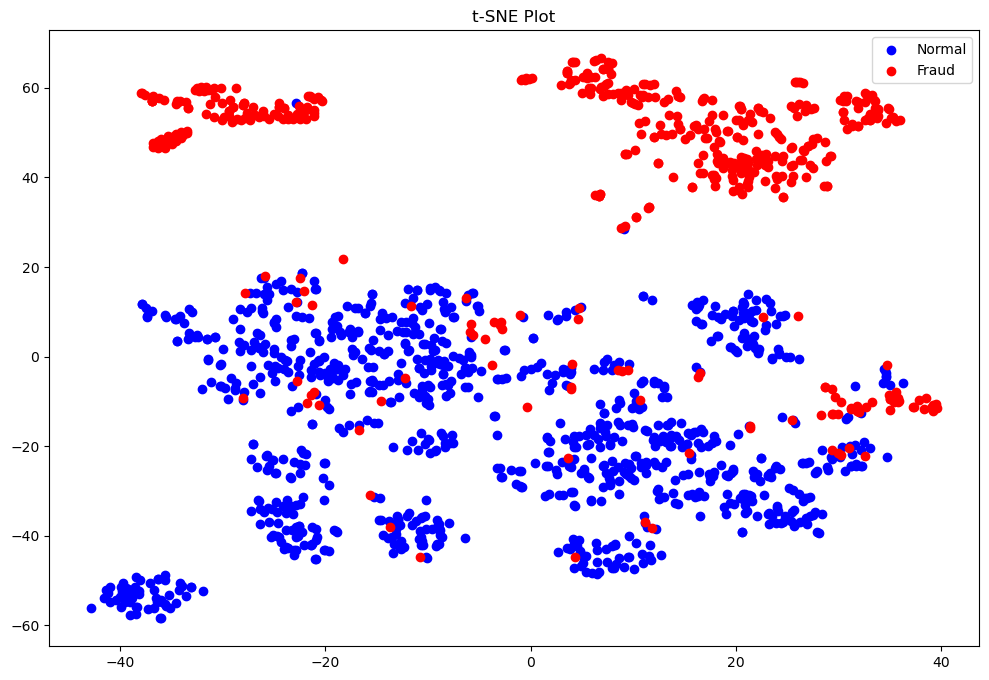

In [18]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

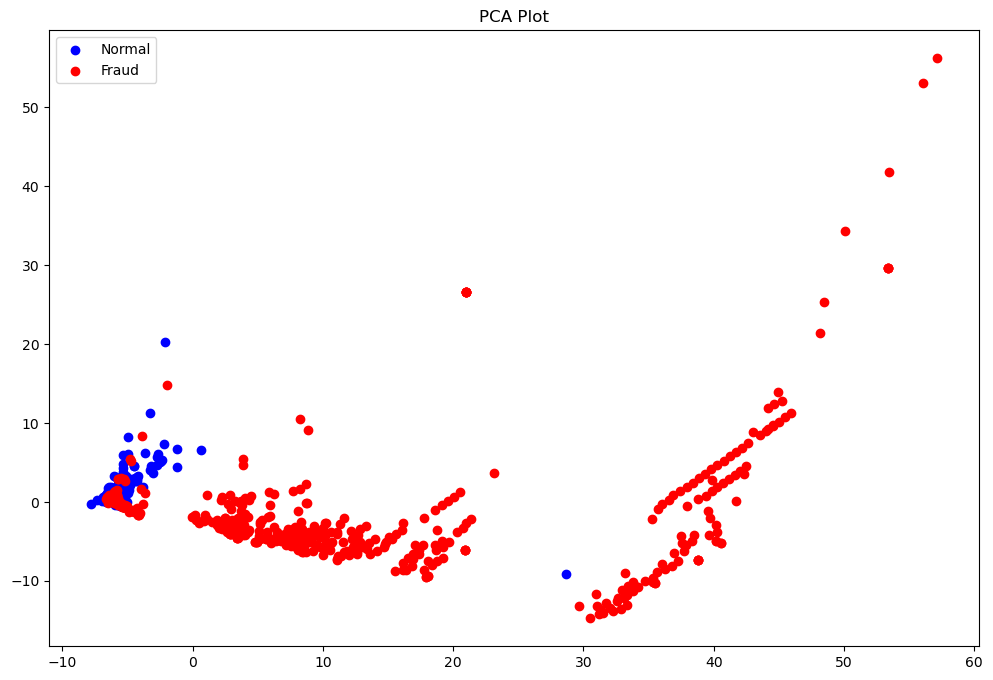

In [21]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [106]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### AutoEncoder Model

In [126]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Reshape((input_dim, 1,))(input_layer)
encoder = Conv1D(14, 3, padding='SAME', activation="relu")(encoder)
encoder = MaxPool1D(pool_size=2)(encoder)
encoder = Conv1D(7, 3, padding='SAME', activation="relu")(encoder)
encoder = MaxPool1D(pool_size=2)(encoder)

decoder = Conv1DTranspose(14, 3, 2, padding='SAME', activation="relu")(encoder)
decoder = Conv1DTranspose(1, 3, 2, padding='SAME', activation="relu")(decoder)
decoder = Reshape((input_dim,))(decoder)

decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 28)]              0         
                                                                 
 reshape_35 (Reshape)        (None, 28, 1)             0         
                                                                 
 conv1d_101 (Conv1D)         (None, 28, 14)            56        
                                                                 
 max_pooling1d_91 (MaxPooli  (None, 14, 14)            0         
 ng1D)                                                           
                                                                 
 conv1d_102 (Conv1D)         (None, 14, 7)             301       
                                                                 
 max_pooling1d_92 (MaxPooli  (None, 7, 7)              0         
 ng1D)                                                    

In [127]:
epochs = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudConv_AE.pth", verbose=0, save_best_only=True)

### Training

In [129]:
history = autoencoder.fit(np.array(X_train), np.array(X_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.7234 - accuracy: 0.7109INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 28s 5ms/step - loss: 0.7231 - accuracy: 0.7112 - val_loss: 0.6072 - val_accuracy: 0.8342
Epoch 2/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.8539INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.6195 - accuracy: 0.8539 - val_loss: 0.5872 - val_accuracy: 0.8685
Epoch 3/100
5598/5598 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.8715INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.6094 - accuracy: 0.8715 - val_loss: 0.5801 - val_accuracy: 0.8833
Epoch 4/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.6052 - accuracy: 0.8809 - val_loss: 0.5823 - val_accuracy: 0.8814
Epoch 5/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6026 - accuracy: 0.8855INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.6034 - accuracy: 0.8855 - val_loss: 0.5764 - val_accuracy: 0.8913
Epoch 6/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6024 - accuracy: 0.8889INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.6023 - accuracy: 0.8889 - val_loss: 0.5748 - val_accuracy: 0.8996
Epoch 7/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6020 - accuracy: 0.8902INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.6018 - accuracy: 0.8902 - val_loss: 0.5741 - val_accuracy: 0.8975
Epoch 8/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.6009 - accuracy: 0.8931 - val_loss: 0.5745 - val_accuracy: 0.8989
Epoch 9/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.6008 - accuracy: 0.8928INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.6007 - accuracy: 0.8928 - val_loss: 0.5735 - val_accuracy: 0.9042
Epoch 10/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.6004 - accuracy: 0.8958INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.6003 - accuracy: 0.8958 - val_loss: 0.5734 - val_accuracy: 0.9001
Epoch 11/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.8991INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.5995 - accuracy: 0.8991 - val_loss: 0.5727 - val_accuracy: 0.9042
Epoch 12/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.5993 - accuracy: 0.8986 - val_loss: 0.5731 - val_accuracy: 0.9027
Epoch 13/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.9016INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 45s 8ms/step - loss: 0.5987 - accuracy: 0.9016 - val_loss: 0.5719 - val_accuracy: 0.9085
Epoch 14/100
5598/5598 [==============================] - 41s 7ms/step - loss: 0.5987 - accuracy: 0.9023 - val_loss: 0.5722 - val_accuracy: 0.9082
Epoch 15/100
5598/5598 [==============================] - 36s 6ms/step - loss: 0.5985 - accuracy: 0.9021 - val_loss: 0.5720 - val_accuracy: 0.9095
Epoch 16/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5981 - accuracy: 0.9040 - val_loss: 0.5743 - val_accuracy: 0.9003
Epoch 17/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.9035INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 40s 7ms/step - loss: 0.5984 - accuracy: 0.9035 - val_loss: 0.5715 - val_accuracy: 0.9095
Epoch 18/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5978 - accuracy: 0.9048INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 33s 6ms/step - loss: 0.5978 - accuracy: 0.9048 - val_loss: 0.5713 - val_accuracy: 0.9096
Epoch 19/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5980 - accuracy: 0.9053INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 39s 7ms/step - loss: 0.5979 - accuracy: 0.9053 - val_loss: 0.5708 - val_accuracy: 0.9168
Epoch 20/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5975 - accuracy: 0.9064 - val_loss: 0.5708 - val_accuracy: 0.9101
Epoch 21/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5979 - accuracy: 0.9049 - val_loss: 0.5712 - val_accuracy: 0.9123
Epoch 22/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5973 - accuracy: 0.9075INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 41s 7ms/step - loss: 0.5971 - accuracy: 0.9074 - val_loss: 0.5705 - val_accuracy: 0.9173
Epoch 23/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.5972 - accuracy: 0.9066 - val_loss: 0.5706 - val_accuracy: 0.9151
Epoch 24/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.5967 - accuracy: 0.9092 - val_loss: 0.5709 - val_accuracy: 0.9140
Epoch 25/100
5598/5598 [==============================] - 31s 5ms/step - loss: 0.5970 - accuracy: 0.9069 - val_loss: 0.5707 - val_accuracy: 0.9094
Epoch 26/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5966 - accuracy: 0.9091INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 33s 6ms/step - loss: 0.5964 - accuracy: 0.9091 - val_loss: 0.5699 - val_accuracy: 0.9197
Epoch 27/100
5598/5598 [==============================] - 41s 7ms/step - loss: 0.5969 - accuracy: 0.9080 - val_loss: 0.5700 - val_accuracy: 0.9145
Epoch 28/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5965 - accuracy: 0.9094 - val_loss: 0.5701 - val_accuracy: 0.9164
Epoch 29/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5963 - accuracy: 0.9097INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5962 - accuracy: 0.9097 - val_loss: 0.5698 - val_accuracy: 0.9186
Epoch 30/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5962 - accuracy: 0.9101 - val_loss: 0.5699 - val_accuracy: 0.9185
Epoch 31/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.9099INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5960 - accuracy: 0.9099 - val_loss: 0.5696 - val_accuracy: 0.9165
Epoch 32/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5959 - accuracy: 0.9109 - val_loss: 0.5714 - val_accuracy: 0.9072
Epoch 33/100
5598/5598 [==============================] - 37s 7ms/step - loss: 0.5959 - accuracy: 0.9108 - val_loss: 0.5721 - val_accuracy: 0.9008
Epoch 34/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5955 - accuracy: 0.9113 - val_loss: 0.5708 - val_accuracy: 0.9025
Epoch 35/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.9123INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 37s 7ms/step - loss: 0.5955 - accuracy: 0.9123 - val_loss: 0.5691 - val_accuracy: 0.9210
Epoch 36/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5954 - accuracy: 0.9125INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5953 - accuracy: 0.9125 - val_loss: 0.5686 - val_accuracy: 0.9214
Epoch 37/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.5958 - accuracy: 0.9117 - val_loss: 0.5689 - val_accuracy: 0.9199
Epoch 38/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.5953 - accuracy: 0.9090INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5953 - accuracy: 0.9090 - val_loss: 0.5682 - val_accuracy: 0.9192
Epoch 39/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5943 - accuracy: 0.9122INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5943 - accuracy: 0.9122 - val_loss: 0.5671 - val_accuracy: 0.9154
Epoch 40/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.9128INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 35s 6ms/step - loss: 0.5916 - accuracy: 0.9128 - val_loss: 0.5636 - val_accuracy: 0.9124
Epoch 41/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.9159INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 36s 6ms/step - loss: 0.5879 - accuracy: 0.9159 - val_loss: 0.5613 - val_accuracy: 0.9221
Epoch 42/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5871 - accuracy: 0.9178 - val_loss: 0.5616 - val_accuracy: 0.9173
Epoch 43/100
5598/5598 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.9188INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 39s 7ms/step - loss: 0.5874 - accuracy: 0.9188 - val_loss: 0.5610 - val_accuracy: 0.9176
Epoch 44/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5865 - accuracy: 0.9210 - val_loss: 0.5616 - val_accuracy: 0.9161
Epoch 45/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5863 - accuracy: 0.9207INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.5863 - accuracy: 0.9207 - val_loss: 0.5601 - val_accuracy: 0.9296
Epoch 46/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.9224INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 33s 6ms/step - loss: 0.5861 - accuracy: 0.9224 - val_loss: 0.5599 - val_accuracy: 0.9313
Epoch 47/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.9230INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 36s 6ms/step - loss: 0.5860 - accuracy: 0.9230 - val_loss: 0.5598 - val_accuracy: 0.9253
Epoch 48/100
5598/5598 [==============================] - 43s 8ms/step - loss: 0.5858 - accuracy: 0.9235 - val_loss: 0.5606 - val_accuracy: 0.9289
Epoch 49/100
5598/5598 [==============================] - 36s 6ms/step - loss: 0.5857 - accuracy: 0.9227 - val_loss: 0.5599 - val_accuracy: 0.9309
Epoch 50/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5871 - accuracy: 0.9207 - val_loss: 0.5598 - val_accuracy: 0.9285
Epoch 51/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.9246INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5856 - accuracy: 0.9245 - val_loss: 0.5598 - val_accuracy: 0.9273
Epoch 52/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.9253INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 32s 6ms/step - loss: 0.5853 - accuracy: 0.9253 - val_loss: 0.5596 - val_accuracy: 0.9269
Epoch 53/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5854 - accuracy: 0.9258 - val_loss: 0.5614 - val_accuracy: 0.9158
Epoch 54/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5854 - accuracy: 0.9261 - val_loss: 0.5601 - val_accuracy: 0.9279
Epoch 55/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5853 - accuracy: 0.9267 - val_loss: 0.5625 - val_accuracy: 0.9182
Epoch 56/100
5598/5598 [==============================] - 34s 6ms/step - loss: 0.5869 - accuracy: 0.9254 - val_loss: 0.5629 - val_accuracy: 0.8962
Epoch 57/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.5855 - accuracy: 0.9274INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 36s 6ms/step - loss: 0.5853 - accuracy: 0.9274 - val_loss: 0.5590 - val_accuracy: 0.9362
Epoch 58/100
5598/5598 [==============================] - 34s 6ms/step - loss: 0.5850 - accuracy: 0.9275 - val_loss: 0.5593 - val_accuracy: 0.9319
Epoch 59/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.9285INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 40s 7ms/step - loss: 0.5850 - accuracy: 0.9285 - val_loss: 0.5584 - val_accuracy: 0.9373
Epoch 60/100
5598/5598 [==============================] - 40s 7ms/step - loss: 0.5855 - accuracy: 0.9254 - val_loss: 0.5594 - val_accuracy: 0.9308
Epoch 61/100
5598/5598 [==============================] - 39s 7ms/step - loss: 0.5848 - accuracy: 0.9299 - val_loss: 0.5585 - val_accuracy: 0.9356
Epoch 62/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5847 - accuracy: 0.9299 - val_loss: 0.5592 - val_accuracy: 0.9261
Epoch 63/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5848 - accuracy: 0.9298 - val_loss: 0.5587 - val_accuracy: 0.9301
Epoch 64/100
5598/5598 [==============================] - 31s 5ms/step - loss: 0.5849 - accuracy: 0.9299 - val_loss: 0.5604 - val_accuracy: 0.9218
Epoch 65/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5845 - accuracy: 0.9309 - val_loss: 0.5587 - val_a

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5842 - accuracy: 0.9328 - val_loss: 0.5581 - val_accuracy: 0.9453
Epoch 73/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5844 - accuracy: 0.9329 - val_loss: 0.5582 - val_accuracy: 0.9400
Epoch 74/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5849 - accuracy: 0.9306INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 34s 6ms/step - loss: 0.5848 - accuracy: 0.9306 - val_loss: 0.5580 - val_accuracy: 0.9394
Epoch 75/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.9347INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 39s 7ms/step - loss: 0.5840 - accuracy: 0.9347 - val_loss: 0.5578 - val_accuracy: 0.9435
Epoch 76/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5842 - accuracy: 0.9341 - val_loss: 0.5773 - val_accuracy: 0.8626
Epoch 77/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.9350INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 36s 7ms/step - loss: 0.5841 - accuracy: 0.9350 - val_loss: 0.5575 - val_accuracy: 0.9485
Epoch 78/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5843 - accuracy: 0.9330 - val_loss: 0.5580 - val_accuracy: 0.9410
Epoch 79/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5838 - accuracy: 0.9352 - val_loss: 0.5580 - val_accuracy: 0.9409
Epoch 80/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5837 - accuracy: 0.9360 - val_loss: 0.5583 - val_accuracy: 0.9255
Epoch 81/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5839 - accuracy: 0.9348 - val_loss: 0.5576 - val_accuracy: 0.9416
Epoch 82/100
5598/5598 [==============================] - 34s 6ms/step - loss: 0.5837 - accuracy: 0.9373 - val_loss: 0.5581 - val_accuracy: 0.9447
Epoch 83/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5834 - accuracy: 0.9373INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 35s 6ms/step - loss: 0.5836 - accuracy: 0.9373 - val_loss: 0.5575 - val_accuracy: 0.9474
Epoch 84/100
5598/5598 [==============================] - 34s 6ms/step - loss: 0.5835 - accuracy: 0.9371 - val_loss: 0.5588 - val_accuracy: 0.9295
Epoch 85/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5834 - accuracy: 0.9372INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 43s 8ms/step - loss: 0.5834 - accuracy: 0.9372 - val_loss: 0.5573 - val_accuracy: 0.9472
Epoch 86/100
5598/5598 [==============================] - 40s 7ms/step - loss: 0.5834 - accuracy: 0.9366 - val_loss: 0.5597 - val_accuracy: 0.9174
Epoch 87/100
5598/5598 [==============================] - 34s 6ms/step - loss: 0.5834 - accuracy: 0.9375 - val_loss: 0.5577 - val_accuracy: 0.9440
Epoch 88/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.9371INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 35s 6ms/step - loss: 0.5835 - accuracy: 0.9371 - val_loss: 0.5570 - val_accuracy: 0.9500
Epoch 89/100
5594/5598 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.9378INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 35s 6ms/step - loss: 0.5832 - accuracy: 0.9378 - val_loss: 0.5569 - val_accuracy: 0.9462
Epoch 90/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5834 - accuracy: 0.9373 - val_loss: 0.5571 - val_accuracy: 0.9476
Epoch 91/100
5598/5598 [==============================] - 31s 6ms/step - loss: 0.5831 - accuracy: 0.9395 - val_loss: 0.5571 - val_accuracy: 0.9463
Epoch 92/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.9390INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 44s 8ms/step - loss: 0.5831 - accuracy: 0.9390 - val_loss: 0.5568 - val_accuracy: 0.9420
Epoch 93/100
5598/5598 [==============================] - 33s 6ms/step - loss: 0.5833 - accuracy: 0.9373 - val_loss: 0.5583 - val_accuracy: 0.9354
Epoch 94/100
5598/5598 [==============================] - 31s 5ms/step - loss: 0.5833 - accuracy: 0.9387 - val_loss: 0.5598 - val_accuracy: 0.9216
Epoch 95/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.9401INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


INFO:tensorflow:Assets written to: fraudConv_AE.pth\assets


5598/5598 [==============================] - 30s 5ms/step - loss: 0.5830 - accuracy: 0.9401 - val_loss: 0.5567 - val_accuracy: 0.9540
Epoch 96/100
5598/5598 [==============================] - 29s 5ms/step - loss: 0.5831 - accuracy: 0.9384 - val_loss: 0.5572 - val_accuracy: 0.9446
Epoch 97/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.5831 - accuracy: 0.9392 - val_loss: 0.5596 - val_accuracy: 0.9304
Epoch 98/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.5830 - accuracy: 0.9390 - val_loss: 0.5624 - val_accuracy: 0.8905
Epoch 99/100
5598/5598 [==============================] - 38s 7ms/step - loss: 0.5830 - accuracy: 0.9391 - val_loss: 0.5568 - val_accuracy: 0.9488
Epoch 100/100
5598/5598 [==============================] - 32s 6ms/step - loss: 0.5836 - accuracy: 0.9381 - val_loss: 0.5652 - val_accuracy: 0.8888


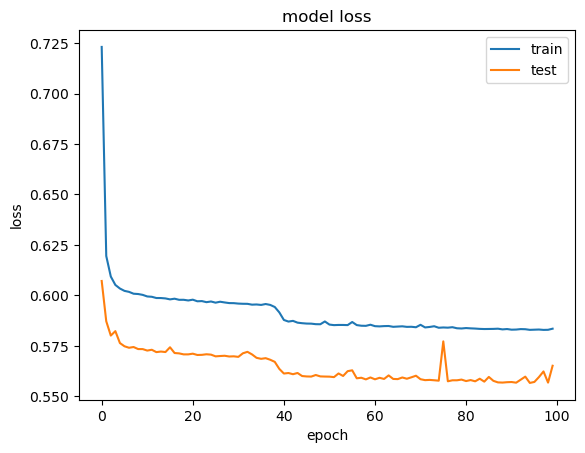

In [130]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [133]:
autoencoder = load_model('fraudConv_AE.pth')

In [134]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 9s 3ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.609077,0.00165
std,3.346469,0.04059
min,0.022899,0.00000
25%,0.176208,0.00000
50%,0.299911,0.00000
75%,0.503776,0.00000
max,395.809706,1.00000


In [135]:
threshold = 2.9

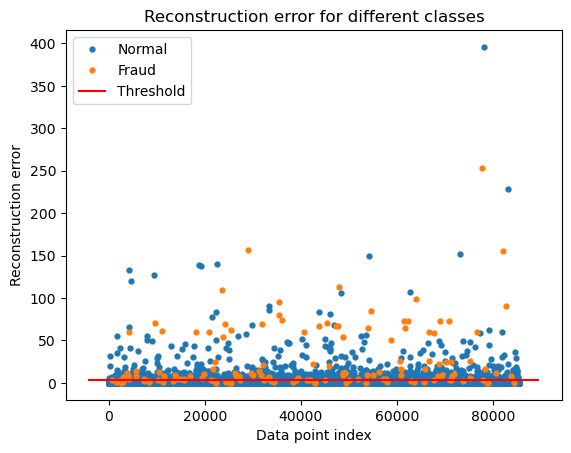

In [136]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

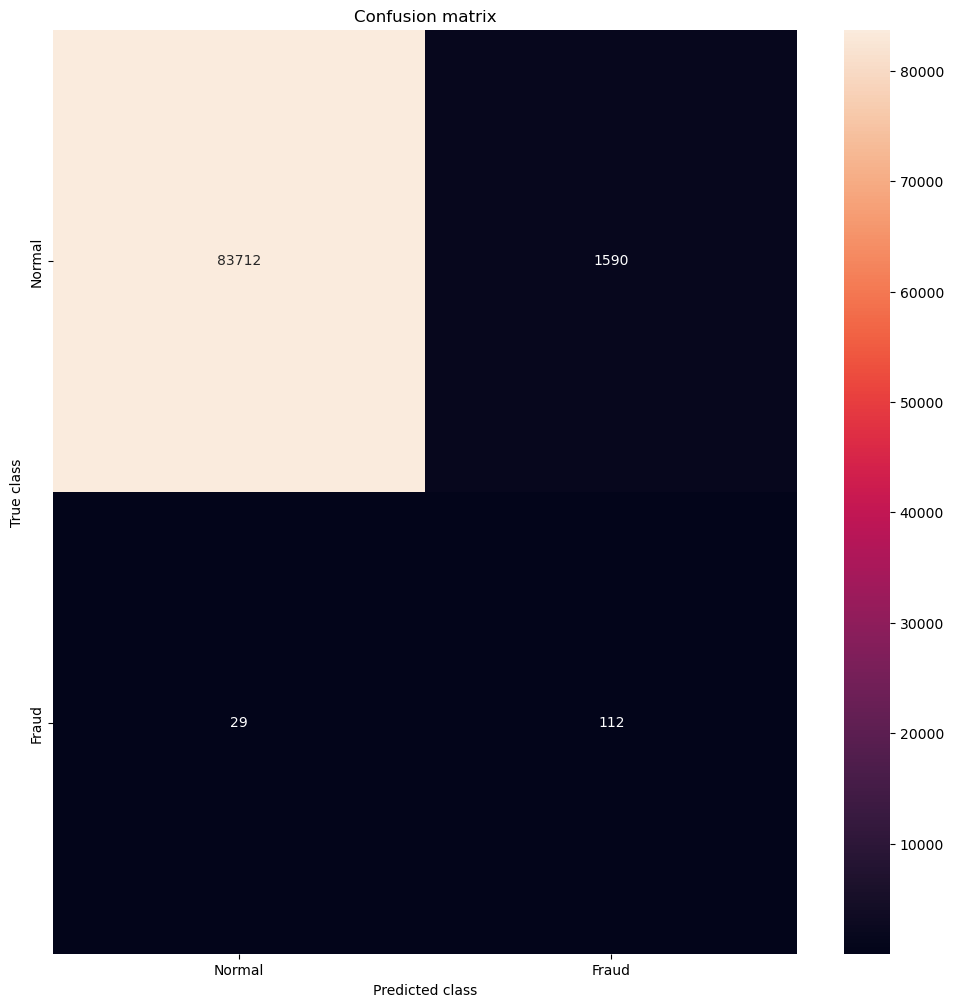

In [137]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [142]:
inp_layer = autoencoder.input
out_layer = autoencoder.layers[5].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [143]:
encoder.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 28)]              0         
                                                                 
 reshape_35 (Reshape)        (None, 28, 1)             0         
                                                                 
 conv1d_101 (Conv1D)         (None, 28, 14)            56        
                                                                 
 max_pooling1d_91 (MaxPooli  (None, 14, 14)            0         
 ng1D)                                                           
                                                                 
 conv1d_102 (Conv1D)         (None, 14, 7)             301       
                                                                 
 max_pooling1d_92 (MaxPooli  (None, 7, 7)              0         
 ng1D)                                                    

In [144]:
fraud = X_test[y_test==1]
normal = X_test[y_test==0]

features = np.append(fraud, normal, axis=0)
labels = np.append(np.ones(len(fraud)), np.zeros(len(normal)))

latent_vector = encoder.predict(features)

2671/2671 [==============================] - 7s 3ms/step


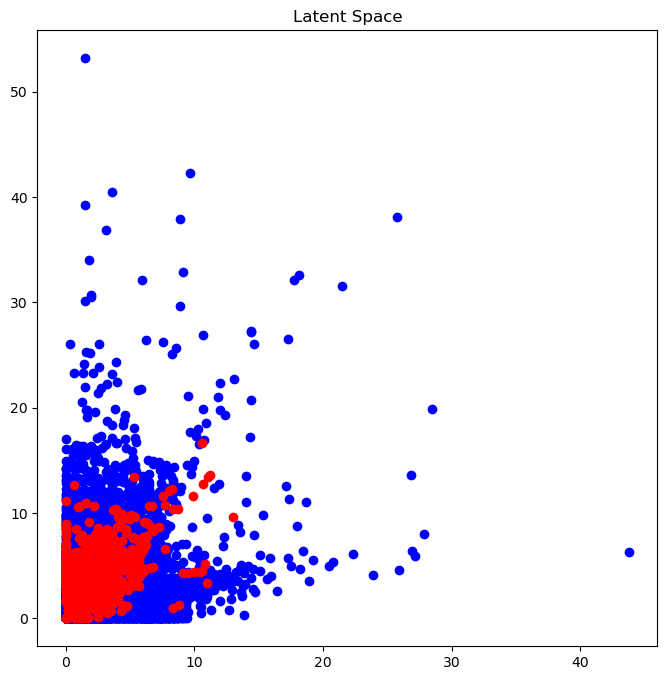

In [145]:
X = latent_vector[:,0]
y = latent_vector[:,1]

plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], color="blue", label='Normal')
plt.scatter(X[labels==1], y[labels==1], color="red", label='Fraud')

plt.title('Latent Space')
plt.show()